# Let's try and simulate the bluebike system as a Gillespie model#
Simplest iteration:
- Model a bike being rented as a poisson process
- Rate of bike removal for each station is derived from the entire month (should really use rates as a rolling window over that month and time of day)
- Timestep of simulation is based on exponential(1/(sum(rental_rates)))
    * Exponential distribution is the prob. dist. of time between events in poisson process. So we want to go one step where one and only one even occurs.
- probability of bike from station A going to Station B is taken from observation of % trips from station A that go to Station B
- trip times are chosen randomly from distribution of all pairwise trips (different for each station-station combo)

### Obvious flaws with basic model ###
- Should have different model for weekday vs. weekend, and possibly each individual day
- Should make rental-rates and transition probbailities depend on time of day. 
- No distinction between subscriber and random user
- Should use more data available
- How to handle arriving at a full station (wait an amount of time, then head to nearby station to dock. adjust loss to some exponential to account for this added annoyance)

### Questions###
- Is the fleet re-balancing included in these stats, or is it separate? How would I know? Would it result in faster or slower trips? An abnormal number of dockings in a short time frame, right?

- What should my loss functions be. Which is worse, not being able to dock because full, or not being able to start because empty. I lean towards not being able to dock, b/c requires grab phone and re-route to 5min away station.
- What should the wait time be at empty/full stations be to see if someone will come along?

### Goals ###
- Find what the right distribution of bikes should be at different stations based on loss fxn.
- find what the right time to reallocate bikes is based on simulations


### More advanced additions ###
- Take weather into account
- add in fleet management nodes that re-stock stations


### First goal: Find the ratio of bikes randomly assigned to each station that minimizes loss fxn: sum(trips ending in full rack + trips starting from empty rack)

Obviously, we shouldn't be randomly assigning bikees to stations, I should use some sort of ranking system involving station popularity, source/sink-ness of a station at a given time. But this is a toy model that will grow more complicated

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load in the data
df = pd.read_csv('../data/201904-bluebikes-tripdata.csv')

In [3]:
def station_probability(df, column):
    '''
    takes in data on number of trips, spits out the
    probability of a random trip starting from that station idi
    
    column: 'start station id' or 'end station id'
    ''' 
    trips_per_station = df[column].value_counts()
    trip_start_probability = trips_per_station / trips_per_station.sum()
    return trip_start_probability
    
prob_start = station_probability(df, 'start station id')
prob_end = station_probability(df, 'end station id')


In [4]:
# Number of stations
start_stations = df['start station id'].unique()
end_stations = df['end station id'].unique()
num_stations = len(np.unique(
    np.concatenate([start_stations, end_stations])
    )
)

In [5]:
num_stations

268

In [6]:
1/268

0.0037313432835820895

## Look at distributions of trip start/stop probability for each station

0.0024505981019112867

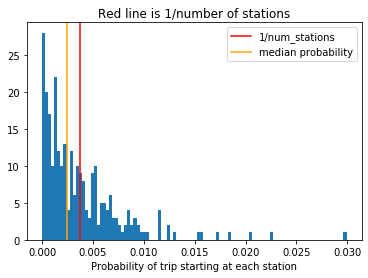

Text(0.5, 1.0, 'Log transform - Red line is 1/number of stations')

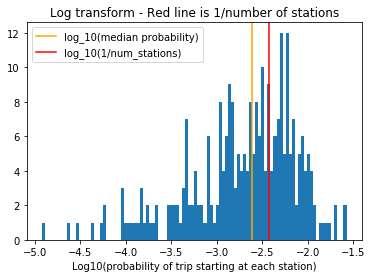

In [58]:
# TODO make relative to the number of stations and docks per station?
prob_start.hist(grid=False, bins=100)
plt.xlabel('Probability of trip starting at each station')
plt.title('Red line is 1/number of stations')
plt.axvline(x=1/num_stations, color='red', label='1/num_stations')
plt.axvline(x=prob_start.median(), color='orange', label='median probability')
plt.legend()
plt.show()

# log transform
((np.log10(prob_end))).hist(grid=False, bins=100)
plt.xlabel('Log10(probability of trip starting at each station)')
plt.axvline(x=np.log10(prob_start.median()), color='orange', label='log_10(median probability)')
plt.axvline(x=np.log10(1/num_stations), color='red',label='log_10(1/num_stations)')
plt.legend()
plt.title('Log transform - Red line is 1/number of stations')

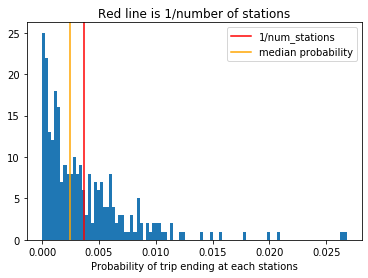

Text(0.5, 1.0, 'Log transform - Red line is 1/number of stations')

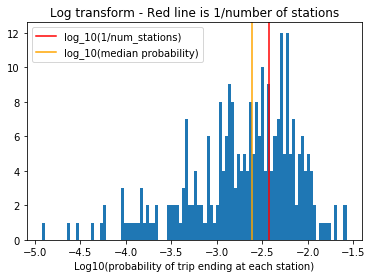

In [60]:
prob_end.hist(grid=False, bins=100)
plt.xlabel('Probability of trip ending at each stations')
plt.axvline(x=1/num_stations, color='red', label='1/num_stations')
plt.axvline(x=prob_start.median(), color='orange', label='median probability')
plt.legend()
plt.title('Red line is 1/number of stations')
plt.show()

# log transform
((np.log10(prob_end))).hist(grid=False, bins=100)
plt.xlabel('Log10(probability of trip ending at each station)')
plt.axvline(x=np.log10(1/num_stations), color='red',label='log_10(1/num_stations)')
plt.axvline(x=np.log10(prob_start.median()), color='orange', label='log_10(median probability)')
plt.legend()

plt.title('Log transform - Red line is 1/number of stations')

## Let's see how many stations are sources vs. sinks relative to their popularity

In [10]:
starts = df['start station id'].value_counts()
ends = df['end station id'].value_counts()

## Normalize these to the number of docks?

Text(0, 0.5, 'ratio of starts to stops')

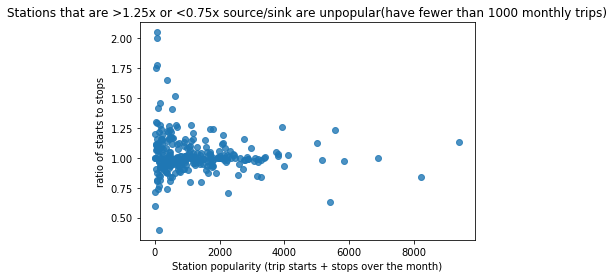

In [69]:
# TODO again
sns.regplot((starts + ends), (starts)/(ends), fit_reg=False,
           )
plt.xlabel('Station popularity (trip starts + stops over the month)')
plt.title(('Stations that are >1.25x or <0.75x source/sink are not popular' +
              '(have fewer than 1000 monthly trips)'))
#plt.title('starts:stops versus number of trip starts+stops')
plt.ylabel('ratio of starts to stops')
#plt.ylabel('aaa')

### So, the system has some definite sources and sink stations at unpopular locations, but for more popular locations the ratio is rarely above 0.75 or 1.25 start:stop

### Let's make a distance matrix of stop-stop probabilities

In [12]:
vals = np.unique(df[['start station id', 'end station id']].values, 
          axis=0)

In [17]:
def make_dict(df):
    '''
    Output a dictionary that counts the number of times a
    trip is taken between two stations
    '''
    counts_dict = {}
    vals = np.unique(df[['start station id', 'end station id']].values,
                    axis=0)
    for i, val in enumerate(vals):
        counts_dict[tuple(val)] = 0
    return counts_dict


def count_pairwise(df):
    pairwise_counts = make_dict(df)
    for i, entry in df[['start station id','end station id']].iterrows():
        pairwise_counts[tuple(entry.values)] += 1
    return pairwise_counts


def pairwise_probability(count_dict):
    '''
    convert dict of tuples into multi-index dataframe
    and outputs probability of trip starting at given 
    dock ends at other docks
    '''
    multi_df = pd.Series(count_dict).to_frame()
    return multi_df.div(multi_df.sum(level=0), level=0)

In [18]:
pairwise_counts = count_pairwise(df)

In [19]:
# number of unique station-station trips taken
len(pairwise_counts.keys())

23679

In [20]:
pairwise_prob = pairwise_probability(pairwise_counts)

In [21]:
pairwise_prob

0
1   1    0.028571
    46   0.028571
    68   0.028571
    71   0.057143
    74   0.028571
    78   0.171429
    94   0.028571
    99   0.371429
    216  0.028571
    378  0.228571
3   1    0.001431
    3    0.087268
    4    0.004292
    5    0.014306
    7    0.001431
    9    0.027182
    10   0.015737
    11   0.010014
    12   0.035765
    14   0.037196
    16   0.008584
    17   0.002861
    19   0.028612
    21   0.025751
    22   0.001431
    26   0.004292
    27   0.015737
    29   0.004292
    30   0.021459
    33   0.025751
...           ...
384 188  0.003906
    189  0.003906
    190  0.003906
    191  0.003906
    206  0.023438
    208  0.007812
    218  0.003906
    221  0.003906
    225  0.015625
    227  0.003906
    228  0.007812
    233  0.003906
    280  0.015625
    327  0.007812
    329  0.003906
    331  0.007812
    335  0.003906
    342  0.019531
    345  0.011719
    352  0.011719
    358  0.007812
    359  0.003906
    361  0.039062
    363  0.007812
    370  0.023438
    372  0.003906
    374  0.003906
    379  0.003906
    380  0.003906
    384  0.046875

[23679 rows x 1 columns]

Text(0.5, 1.0, 'Most station-station trips only occur once (this makes sense b/c combinatorics and large number of pairwise stations)')

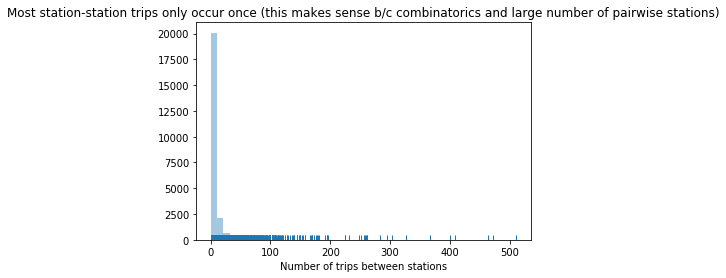

In [436]:
# distribution of # of trips in between stations
sns.distplot(list(pairwise_counts.values()), 
            rug=True, 
            kde=False,
            rug_kws={"alpha": 1, "height": 0.02}
            )
plt.xlabel('Number of trips between stations')
plt.title('Most station-station trips only occur once (this makes sense b/c combinatorics and large number of pairwise stations)')

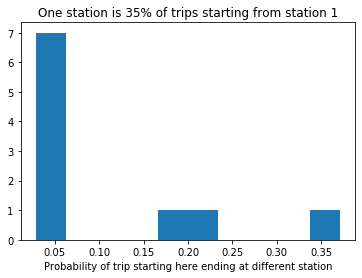

In [24]:
pairwise_prob.loc[1].hist(grid=False)
plt.xlabel('Probability of trip starting here ending at different station')
plt.title('One station is 35% of trips starting from station 1')
plt.show()

Text(0.5, 1.0, 'There is no dominant station for dock 384')

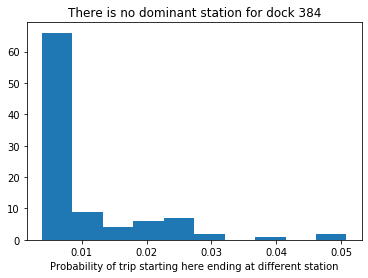

In [25]:
pairwise_prob.loc[384].hist(grid=False)
plt.xlabel('Probability of trip starting here ending at different station')
plt.title('There is no dominant station for dock 384')

### Should try the above as a ridgeline plot for all stations

In [217]:
df[df['start station id'] == 134]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
121751,1056,2019-04-23 15:42:09.7280,2019-04-23 15:59:45.9120,134,Boylston St at Dartmouth St,42.350413,-71.07655,178,MIT Pacific St at Purrington St,42.359573,-71.101295,4538,Subscriber,1992,2
122011,371,2019-04-23 16:17:22.5840,2019-04-23 16:23:33.7370,134,Boylston St at Dartmouth St,42.350413,-71.07655,39,Washington St at Rutland St,42.338515,-71.074041,4137,Subscriber,1961,1
123697,631,2019-04-23 18:22:28.0900,2019-04-23 18:32:59.1520,134,Boylston St at Dartmouth St,42.350413,-71.07655,190,Nashua Street at Red Auerbach Way,42.365673,-71.064263,2070,Subscriber,1989,1
123885,473,2019-04-23 18:39:40.7330,2019-04-23 18:47:34.6170,134,Boylston St at Dartmouth St,42.350413,-71.07655,35,Arch St at Franklin St,42.355335,-71.058229,4132,Customer,1998,2
124122,346,2019-04-23 19:03:35.3040,2019-04-23 19:09:21.5650,134,Boylston St at Dartmouth St,42.350413,-71.07655,53,Beacon St at Massachusetts Ave,42.350827,-71.089811,3539,Subscriber,1993,1
124728,401,2019-04-23 20:42:58.6980,2019-04-23 20:49:39.9300,134,Boylston St at Dartmouth St,42.350413,-71.07655,120,Beacon St at Charles St,42.356052,-71.069849,2073,Subscriber,1968,2
125568,641,2019-04-24 07:19:05.0330,2019-04-24 07:29:46.5880,134,Boylston St at Dartmouth St,42.350413,-71.07655,67,MIT at Mass Ave / Amherst St,42.358100,-71.093198,3783,Subscriber,1995,1
127543,943,2019-04-24 11:26:33.7960,2019-04-24 11:42:16.8540,134,Boylston St at Dartmouth St,42.350413,-71.07655,20,Aquarium T Stop - 200 Atlantic Ave,42.359912,-71.051430,3333,Subscriber,1950,1
127675,5352,2019-04-24 11:52:14.6790,2019-04-24 13:21:27.5770,134,Boylston St at Dartmouth St,42.350413,-71.07655,369,Boston Public Market,42.362549,-71.057374,2290,Customer,1994,1
127677,5311,2019-04-24 11:52:38.3970,2019-04-24 13:21:09.6030,134,Boylston St at Dartmouth St,42.350413,-71.07655,369,Boston Public Market,42.362549,-71.057374,2451,Customer,1994,1


### TODO distribution of trip times for pairwise trips, rate of bike rental

In [222]:
# Get number of trips per minute, divide by 16-hour days, 30 days in april
df.shape[0] / (30*16*60)

5.7879861111111115

In [237]:
# get the dist of trip times for each station combo
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

#### Get the number of docks at each station

In [27]:
df.set_index(['start station id', 'end station id'], append=True)

,,,tripduration,starttime,stoptime,start station name,start station latitude,start station longitude,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
,start station id,end station id,,,,,,,,,,,,,
0,8,8,3363,2019-04-01 00:04:38.1400,2019-04-01 01:00:41.6390,Union Square - Brighton Ave at Cambridge St,42.353334,-71.137313,Union Square - Brighton Ave at Cambridge St,42.353334,-71.137313,3736,Customer,1969,0
1,108,66,1206,2019-04-01 00:06:40.0030,2019-04-01 00:26:46.1020,Harvard University / SEAS Cruft-Pierce Halls a...,42.377945,-71.116865,Allston Green District - Griggs St at Commonwe...,42.349225,-71.132753,4472,Customer,1993,1
2,177,68,123,2019-04-01 00:07:15.5800,2019-04-01 00:09:18.7640,University Park,42.362648,-71.100061,Central Square at Mass Ave / Essex St,42.365070,-71.103100,2621,Subscriber,1990,1
3,157,89,2056,2019-04-01 00:11:03.2790,2019-04-01 00:45:19.8910,Seaport Blvd at Sleeper St,42.353178,-71.048174,Harvard Law School at Mass Ave / Jarvis St,42.379011,-71.119945,4470,Subscriber,1969,1
4,110,79,165,2019-04-01 00:13:56.8360,2019-04-01 00:16:42.0680,Harvard University Gund Hall at Quincy St / Ki...,42.376369,-71.114025,Beacon St at Washington / Kirkland,42.378420,-71.105668,2589,Subscriber,1988,1
5,10,66,650,2019-04-01 00:14:44.3920,2019-04-01 00:25:34.8820,B.U. Central - 725 Comm. Ave.,42.350406,-71.108279,Allston Green District - Griggs St at Commonwe...,42.349225,-71.132753,4168,Subscriber,1994,1
6,335,179,649,2019-04-01 00:22:08.5300,2019-04-01 00:32:58.2450,Harvard St at Greene-Rose Heritage Park,42.365994,-71.095222,MIT Vassar St,42.355601,-71.103945,4084,Subscriber,1995,1
7,67,178,258,2019-04-01 00:30:25.0840,2019-04-01 00:34:43.9840,MIT at Mass Ave / Amherst St,42.358100,-71.093198,MIT Pacific St at Purrington St,42.359573,-71.101295,2370,Subscriber,1994,1
8,33,9,647,2019-04-01 00:32:29.7250,2019-04-01 00:43:16.8230,Kenmore Square,42.348706,-71.097009,Commonwealth Ave at Agganis Way,42.351692,-71.119035,4026,Customer,1969,0


In [270]:
df2 = pd.DataFrame({'id_user':[1,2,3,4,4,5,5], 
'information':['phon','phon','phone','phone1','phone','phone1','phone'], 
'value': [1, '01.01.00', '01.02.00', 2, '01.03.00', 3, '01.04.00']})

In [28]:
grouped = df.groupby(['start station id', 'end station id'])

In [29]:
pd.concat([grouped.tripduration.mean(), 
           grouped.tripduration.std()]
         , axis=1, keys=['mean', 'std'])

mean          std
start station id end station id                            
1                1                  790.000000          NaN
                 46                1535.000000          NaN
                 68                 880.000000          NaN
                 71                1006.500000    34.648232
                 74                1398.000000          NaN
                 78                 551.000000    89.913292
                 94                 634.000000          NaN
                 99                1081.000000    83.610207
                 216             170826.000000          NaN
                 378                853.625000   159.733651
3                1                14021.000000          NaN
                 3                 2185.540984  1682.077986
                 4                  944.666667   289.717679
                 5                  620.800000   338.760420
                 7                 2604.000000          NaN
                 9                  835.789474   472.685893
                 10                 632.818182   197.667305
                 11                 826.714286  1224.048163
                 12                 403.040000   108.506329
                 14                 139.846154   209.061655
                 16                1064.166667   265.456148
                 17                2157.000000   115.965512
                 19                 505.600000   697.280764
                 21                 826.833333   317.308210
                 22                1406.000000          NaN
                 26                1029.666667   198.799732
                 27                 539.272727   152.622469
                 29                1821.666667   291.132845
                 30                 570.400000   440.937929
                 33                 813.833333   570.038621
...                                        ...          ...
384              188               1707.000000          NaN
                 189               1576.000000          NaN
                 190                981.000000          NaN
                 191               1749.000000          NaN
                 206                494.500000   105.545725
                 208               2479.000000   274.357431
                 218                739.000000          NaN
                 221               1413.000000          NaN
                 225                997.000000   206.847770
                 227                516.000000          NaN
                 228                784.000000     0.000000
                 233                641.000000          NaN
                 280               1365.500000    62.740205
                 327               1167.000000   255.972655
                 329               1708.000000          NaN
                 331               1598.500000     6.363961
                 335                637.000000          NaN
                 342                640.000000   155.958328
                 345               1249.333333  1057.140167
                 352                215.333333    38.695392
                 358               1289.500000    45.961941
                 359                946.000000          NaN
                 361                965.300000   308.131303
                 363                509.500000   108.187338
                 370                404.333333   609.579090
                 372                737.000000          NaN
                 374               1485.000000          NaN
                 379                439.000000          NaN
                 380                527.000000          NaN
                 384               3835.916667  3043.195105

[23679 rows x 2 columns]

In [337]:
grouped.cumcount(ascending=False).sort_values()

166693      0
110823      0
19750       0
148924      0
110821      0
110816      0
19745       0
148928      0
148929      0
110813      0
148933      0
148921      0
110808      0
53351       0
110787      0
110786      0
110778      0
110774      0
148948      0
148949      0
148951      0
148953      0
19722       0
110799      0
19721       0
53328       0
110838      0
148887      0
148888      0
110876      0
         ... 
54472     480
54418     481
54170     482
53573     483
53527     484
52404     485
52212     486
52211     487
51958     488
51858     489
51852     490
51794     491
51782     492
50931     493
50811     494
50027     495
49635     496
49615     497
49175     498
48981     499
48564     500
48331     501
48278     502
48188     503
47620     504
47365     505
46702     506
45719     507
43386     508
42097     509
Length: 166694, dtype: int64

In [30]:
df.iloc[42097,:]

tripduration                                          186
starttime                        2019-04-09 12:49:04.9600
stoptime                         2019-04-09 12:52:11.3690
start station id                                       53
start station name         Beacon St at Massachusetts Ave
start station latitude                            42.3508
start station longitude                          -71.0898
end station id                                         67
end station name             MIT at Mass Ave / Amherst St
end station latitude                              42.3581
end station longitude                            -71.0932
bikeid                                               3993
usertype                                       Subscriber
birth year                                           1999
gender                                                  1
Name: 42097, dtype: object

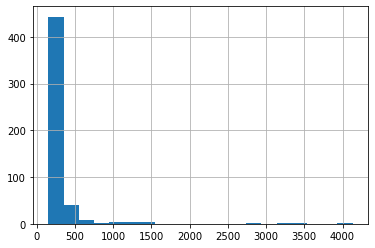

In [342]:
# plot trip duration for all trips starting at station 53, ending at 67 
(df[(df['start station id'] == 53) 
    & (df['end station id'] == 67)]
 .tripduration
 .hist(bins=20)
)

### Again, should I make a ridgeline plot of all these tripduration times? 
##### 26,000 might be too many plots...?

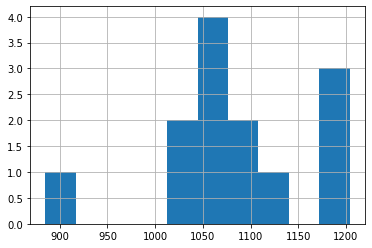

In [334]:
(df[(df['start station id'] == 1) 
    & (df['end station id'] == 99)]
 .tripduration
 .hist()
)

In [316]:

[df[df.tripduration > (i*60*60)].shape[0] for i in range(1, 10)]

[6206, 1282, 660, 517, 450, 405, 375, 359, 337]

# TODO
How to sample appropriately? 

Could just draw a number from the actual observed trip durations
and add a random amount of noise to it?

In [34]:
# remove trips longer than 5 hours - i assume these are funky
# possibly mis-docks or something joy rides or maybe even the fleet management? 
df2 = df[df.tripduration <= (5*60*60)]

Text(0.5, 0, 'count')

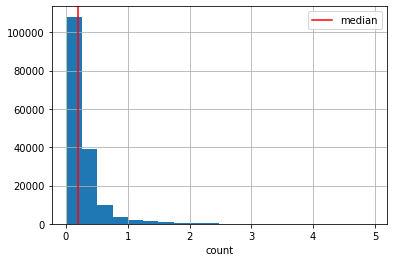

In [44]:
# trip durations less than 5 hours long
(df2.tripduration / 3600).hist(bins=20)
plt.xlabel('Trip duration (hours)')
plt.axvline(x=(df2.tripduration.median() / 3600), color='red', label='median')
plt.legend()
plt.xlabel('count')

In [39]:
df2.tripduration.median()

693.0

In [311]:
60*60*24*30

2592000

In [ ]:
def gillespie(num_sim, )